Loading UAV data...
Found 36 UAV files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
Data loaded successfully!
Loaded data from 36 UAVs
Total data points: 185705
Original time range: 20.68s - 667.18s
Time step: 1.0s
Start time set to: 60.0s

Starting cluster size analysis...
Analyzing 608 timesteps (from 60.00s to 667.18s)...
Original time range: 20.68s - 667.18s
Start time set to: 60.0s, actual start: 60.0s
Processing timestep 0/608 (time = 60.00s)
Processing timestep 152/608 (time = 212.00s)
Processing timestep 304/608 (time = 364.00s)
Processing timestep 456/608 (time = 516.00s)
Processing timestep 607/608 (time = 667.00s)


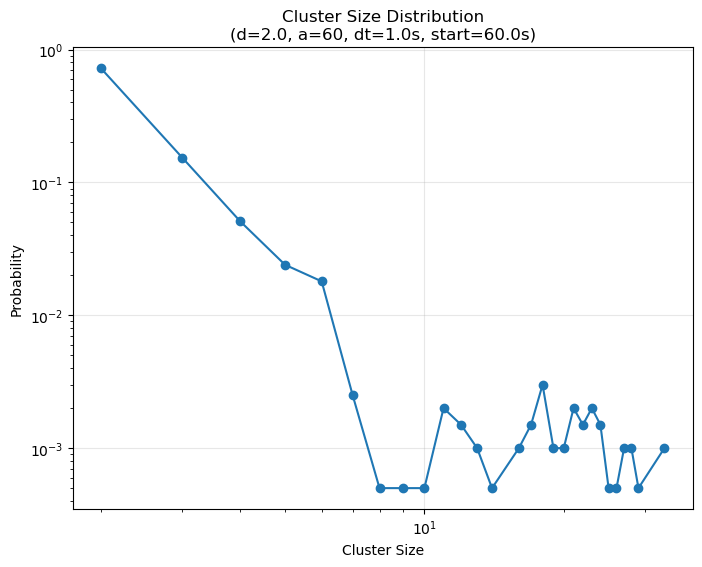

Cluster size analysis completed. Found 1999 clusters.
Size range: 2 - 33
Average cluster size: 2.85

Starting cluster duration analysis...
Tracking cluster evolution over 608 timesteps...
Time range: 60.00s - 667.18s
Processing timestep 0/608 (time = 60.00s)
Processing timestep 121/608 (time = 181.00s)
Processing timestep 242/608 (time = 302.00s)
Processing timestep 363/608 (time = 423.00s)
Processing timestep 484/608 (time = 544.00s)
Processing timestep 605/608 (time = 665.00s)
Processing timestep 607/608 (time = 667.00s)


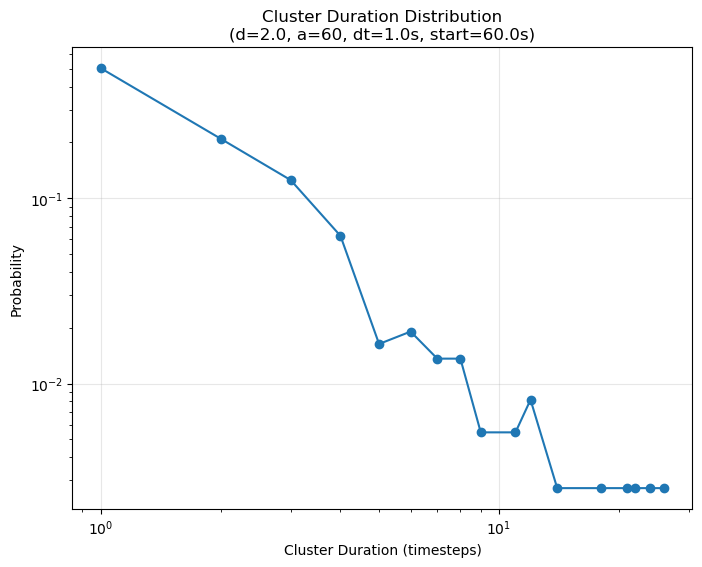

Cluster duration analysis completed. Found 367 cluster instances.
Duration range: 1 - 26 timesteps
Average cluster duration: 2.50 timesteps

=== Final Statistical Summary ===
Total UAVs analyzed: 36
Total timesteps analyzed: 607
Time step size: 1.0s
Start time: 60.0s
Distance threshold: 2.0m
Angle threshold: 60°
Total clusters found: 1999
Cluster size statistics: min=2, max=33, mean=2.85
Cluster duration statistics: min=1, max=26, mean=2.50


In [1]:
# 相关簇分析 - 无人机实验数据（统一时间步长版本）
# 计算与展示

import matplotlib as mpl
import matplotlib.pyplot as plt

# 设置matplotlib参数
%matplotlib inline
mpl.rc('figure', figsize=(10, 5))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
import os
import math
import glob
from itertools import combinations

# 相关簇分析参数
distance_threshold = 2.0  # 距离阈值（米）
angle_threshold = 60      # 角度阈值（度）
time_step = 1.0          # 时间步长（秒）
start_time = 60.0        # 计算起始时间（秒）

# 实验配置
experiment_time = '20251125_200214'
data_dir = f'uav_data/experiment_{experiment_time}/raw_data'
output_dir = f'uav_data/experiment_{experiment_time}/process_result'

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 自动检测无人机文件
def detect_uav_files(data_dir, experiment_time):
    """
    自动检测raw_data文件夹中的无人机文件
    """
    pattern = os.path.join(data_dir, f"uav_*_experiment_{experiment_time}.csv")
    uav_files = glob.glob(pattern)
    
    # 提取无人机ID并排序
    uav_ids = []
    for file_path in uav_files:
        filename = os.path.basename(file_path)
        # 从文件名中提取无人机ID，如 uav_0_experiment_20251125_111743.csv -> 0
        parts = filename.split('_')
        if len(parts) >= 2 and parts[0] == 'uav' and parts[1].isdigit():
            uav_ids.append(int(parts[1]))
    
    uav_ids.sort()
    return uav_ids

# 读取无人机数据
def read_uav_data(file_path, uav_id):
    """
    读取单个无人机的CSV数据文件
    """
    try:
        df = pd.read_csv(file_path)
        df['uav_id'] = uav_id
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def load_all_uav_data(data_dir, experiment_time):
    """
    加载所有无人机的数据
    """
    all_data = []
    
    # 自动检测无人机文件
    uav_ids = detect_uav_files(data_dir, experiment_time)
    
    if not uav_ids:
        print(f"No UAV files found in {data_dir}")
        return all_data
    
    print(f"Found {len(uav_ids)} UAV files: {uav_ids}")
    
    for uav_id in uav_ids:
        filename = f"uav_{uav_id}_experiment_{experiment_time}.csv"
        file_path = os.path.join(data_dir, filename)
        
        df = read_uav_data(file_path, uav_id)
        if df is not None:
            all_data.append(df)
            # print(f"Successfully loaded data for UAV {uav_id}: {len(df)} records")
        else:
            print(f"Warning: Failed to load data for UAV {uav_id}")
    
    return all_data

# 计算两个向量的夹角（角度制）
def angle_between(v1_x, v1_y, v2_x, v2_y):
    v1 = np.array([v1_x, v1_y])
    v2 = np.array([v2_x, v2_y])
    
    # 检查零向量
    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        return 0
    
    dot_product = np.dot(v1, v2)
    norms = np.linalg.norm(v1) * np.linalg.norm(v2)
    
    cos_theta = dot_product / norms
    cos_theta = np.clip(cos_theta, -1.0, 1.0)  # 确保在有效范围内
    angle_in_radians = np.arccos(cos_theta)
    angle_in_degrees = np.degrees(angle_in_radians)
    return angle_in_degrees

# 计算两个无人机之间的距离
def calculate_distance(pos1_x, pos1_y, pos2_x, pos2_y):
    return np.sqrt((pos2_x - pos1_x) ** 2 + (pos2_y - pos1_y) ** 2)

# 检查两个无人机是否相关
def are_correlated(uav1_data, uav2_data, distance_thresh, angle_thresh):
    """
    检查两个无人机在xy平面上是否相关
    """
    # 计算距离
    dist = calculate_distance(uav1_data['pos_x'], uav1_data['pos_y'], 
                            uav2_data['pos_x'], uav2_data['pos_y'])
    
    # 计算速度夹角
    angle = angle_between(uav1_data['vel_x'], uav1_data['vel_y'],
                         uav2_data['vel_x'], uav2_data['vel_y'])
    
    return (dist < distance_thresh) and (angle < angle_thresh)

# 深度优先搜索查找相关簇
def find_correlated_clusters(uavs_data, distance_thresh, angle_thresh):
    """
    在单个时间步长中查找相关簇
    """
    n_uavs = len(uavs_data)
    visited = [False] * n_uavs
    clusters = []
    
    def dfs(uav_idx, cluster):
        visited[uav_idx] = True
        cluster.append(uav_idx)
        
        # 查找未访问的相关邻居
        for other_idx in range(n_uavs):
            if not visited[other_idx]:
                if are_correlated(uavs_data[uav_idx], uavs_data[other_idx], 
                                distance_thresh, angle_thresh):
                    dfs(other_idx, cluster)
        
        return cluster
    
    for i in range(n_uavs):
        if not visited[i]:
            cluster = dfs(i, [])
            clusters.append(cluster)
    
    return clusters

# 查找最接近指定时间的无人机数据
def find_closest_data_point(uav_data, target_time):
    """
    在无人机数据中找到最接近目标时间的数据点
    """
    if uav_data.empty:
        return None
    
    # 计算时间差
    time_diffs = np.abs(uav_data['sim_time'] - target_time)
    min_idx = time_diffs.idxmin()
    
    # 如果时间差太大，可能没有有效数据
    if time_diffs[min_idx] > time_step / 2:  # 允许半个时间步长的误差
        return None
    
    return uav_data.iloc[min_idx]

# 获取统一时间步长的数据
def get_unified_timestep_data(all_uav_data, target_time):
    """
    获取所有无人机在指定时间步长的数据
    """
    unified_data = []
    
    for uav_id, uav_df in enumerate(all_uav_data):
        closest_data = find_closest_data_point(uav_df, target_time)
        if closest_data is not None:
            unified_data.append(closest_data)
    
    return unified_data

# 分析相关簇大小分布
def analyze_cluster_sizes(all_uav_data, distance_thresh, angle_thresh, time_step, start_time):
    """
    分析所有时间步的相关簇大小分布（统一时间步长）
    """
    avalanche_sizes = []
    
    # 确定时间范围
    all_sim_times = []
    for uav_data in all_uav_data:
        if not uav_data.empty:
            all_sim_times.extend(uav_data['sim_time'].values)
    
    if not all_sim_times:
        return avalanche_sizes
    
    min_time = min(all_sim_times)
    max_time = max(all_sim_times)
    
    # 调整起始时间，确保不小于最小时间
    actual_start_time = max(min_time, start_time)
    
    # 生成统一的时间步长序列（从start_time开始）
    time_steps = np.arange(actual_start_time, max_time, time_step)
    
    print(f"Analyzing {len(time_steps)} timesteps (from {actual_start_time:.2f}s to {max_time:.2f}s)...")
    print(f"Original time range: {min_time:.2f}s - {max_time:.2f}s")
    print(f"Start time set to: {start_time}s, actual start: {actual_start_time}s")
    
    # 计算进度显示间隔（总长度的1/4）
    progress_interval = max(1, len(time_steps) // 4)
    
    for i, target_time in enumerate(time_steps):
        # 进度显示（总长度的1/4间隔）
        if i % progress_interval == 0 or i == len(time_steps) - 1:
            print(f"Processing timestep {i}/{len(time_steps)} (time = {target_time:.2f}s)")
        
        # 获取当前时间步的所有无人机数据
        current_data = get_unified_timestep_data(all_uav_data, target_time)
        
        if len(current_data) < 2:  # 至少需要2架无人机才能形成簇
            continue
        
        # 查找相关簇
        clusters = find_correlated_clusters(current_data, distance_thresh, angle_thresh)
        
        # 记录簇大小（排除大小为1的簇）
        for cluster in clusters:
            if len(cluster) > 1:  # 只考虑大小大于1的簇
                avalanche_sizes.append(len(cluster))
    
    return avalanche_sizes

# 分析相关簇持续时间
def analyze_cluster_duration(all_uav_data, distance_thresh, angle_thresh, time_step, start_time):
    """
    分析相关簇的持续时间分布（统一时间步长）
    """
    # 确定时间范围
    all_sim_times = []
    for uav_data in all_uav_data:
        if not uav_data.empty:
            all_sim_times.extend(uav_data['sim_time'].values)
    
    if not all_sim_times:
        return []
    
    min_time = min(all_sim_times)
    max_time = max(all_sim_times)
    
    # 调整起始时间，确保不小于最小时间
    actual_start_time = max(min_time, start_time)
    
    # 生成统一的时间步长序列（从start_time开始）
    time_steps = np.arange(actual_start_time, max_time, time_step)
    
    cluster_evolution = {}  # 跟踪簇的演变
    cluster_history = []    # 记录每个时间步的簇
    
    print(f"Tracking cluster evolution over {len(time_steps)} timesteps...")
    print(f"Time range: {actual_start_time:.2f}s - {max_time:.2f}s")
    
    # 计算进度显示间隔（总长度的1/5）
    progress_interval = max(1, len(time_steps) // 5)
    
    for i, target_time in enumerate(time_steps):
        # 进度显示（总长度的1/5间隔）
        if i % progress_interval == 0 or i == len(time_steps) - 1:
            print(f"Processing timestep {i}/{len(time_steps)} (time = {target_time:.2f}s)")
        
        current_data = get_unified_timestep_data(all_uav_data, target_time)
        
        if len(current_data) < 2:
            cluster_history.append([])
            continue
        
        # 查找当前时间步的簇
        current_clusters = find_correlated_clusters(current_data, distance_thresh, angle_thresh)
        current_cluster_ids = [tuple(sorted([current_data[idx]['uav_id'] for idx in cluster])) 
                             for cluster in current_clusters if len(cluster) > 1]
        
        cluster_history.append(current_cluster_ids)
        
        # 更新簇跟踪
        for cluster_id in current_cluster_ids:
            if cluster_id in cluster_evolution:
                if cluster_evolution[cluster_id]['active']:
                    cluster_evolution[cluster_id]['duration'] += 1
                    cluster_evolution[cluster_id]['last_seen'] = target_time
                else:
                    # 簇重新出现，开始新的持续时间记录
                    cluster_evolution[cluster_id] = {
                        'start': target_time,
                        'last_seen': target_time,
                        'duration': 1,
                        'active': True
                    }
            else:
                cluster_evolution[cluster_id] = {
                    'start': target_time,
                    'last_seen': target_time,
                    'duration': 1,
                    'active': True
                }
        
        # 标记在当前时间步未出现的簇为不活跃
        for cluster_id in cluster_evolution:
            if cluster_evolution[cluster_id]['active'] and cluster_id not in current_cluster_ids:
                cluster_evolution[cluster_id]['active'] = False
    
    # 提取持续时间
    durations = [info['duration'] for info in cluster_evolution.values()]
    return durations

# 计算概率分布
def calculate_probability_distribution(values):
    """
    计算值的概率分布
    """
    if len(values) == 0:
        return np.array([]), np.array([])
    
    unique_values, counts = np.unique(values, return_counts=True)
    probabilities = counts / len(values)
    return unique_values, probabilities

# 绘制分布图
def plot_distribution(values, probabilities, title, xlabel, save_path=None):
    """
    绘制概率分布图
    """
    if len(values) == 0:
        print("No data to plot!")
        return
    
    plt.figure(figsize=(8, 6))
    plt.plot(values, probabilities, 'o-', markersize=6)
    plt.xlabel(xlabel)
    plt.ylabel('Probability')
    plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# 主分析流程
print("Loading UAV data...")
all_uav_data = load_all_uav_data(data_dir, experiment_time)

if all_uav_data and any(not df.empty for df in all_uav_data):
    print("Data loaded successfully!")
    
    # 统计信息
    valid_uavs = sum(1 for df in all_uav_data if not df.empty)
    total_data_points = sum(len(df) for df in all_uav_data if not df.empty)
    
    print(f"Loaded data from {valid_uavs} UAVs")
    print(f"Total data points: {total_data_points}")
    
    # 确定时间范围
    all_sim_times = []
    for uav_data in all_uav_data:
        if not uav_data.empty:
            all_sim_times.extend(uav_data['sim_time'].values)
    
    min_time = min(all_sim_times)
    max_time = max(all_sim_times)
    print(f"Original time range: {min_time:.2f}s - {max_time:.2f}s")
    print(f"Time step: {time_step}s")
    print(f"Start time set to: {start_time}s")
    
    # 检查起始时间是否合理
    if start_time < min_time:
        print(f"Warning: Start time {start_time}s is before data start time {min_time:.2f}s")
        print(f"Using actual start time: {min_time:.2f}s")
    elif start_time > max_time:
        print(f"Error: Start time {start_time}s is after data end time {max_time:.2f}s")
        print("No data to analyze!")
        exit()
    
    print("\nStarting cluster size analysis...")
    
    # 分析簇大小分布
    cluster_sizes = analyze_cluster_sizes(all_uav_data, distance_threshold, angle_threshold, time_step, start_time)
    
    if cluster_sizes:
        size_values, size_probs = calculate_probability_distribution(cluster_sizes)
        
        # 保存结果到指定目录
        np.savetxt(os.path.join(output_dir, f'uav_cluster_sizes_d{distance_threshold}_a{angle_threshold}_ts{time_step}_start{start_time}.txt'), 
                   cluster_sizes, fmt='%d')
        np.savetxt(os.path.join(output_dir, f'uav_cluster_size_values_d{distance_threshold}_a{angle_threshold}_ts{time_step}_start{start_time}.txt'), 
                   size_values, fmt='%d')
        np.savetxt(os.path.join(output_dir, f'uav_cluster_size_probs_d{distance_threshold}_a{angle_threshold}_ts{time_step}_start{start_time}.txt'), 
                   size_probs, fmt='%f')
        
        # 绘制簇大小分布
        plot_distribution(size_values, size_probs, 
                         f'Cluster Size Distribution\n(d={distance_threshold}, a={angle_threshold}, dt={time_step}s, start={start_time}s)',
                         'Cluster Size',
                         os.path.join(output_dir, f'uav_cluster_size_dist_d{distance_threshold}_a{angle_threshold}_ts{time_step}_start{start_time}.png'))
        
        print(f"Cluster size analysis completed. Found {len(cluster_sizes)} clusters.")
        print(f"Size range: {min(cluster_sizes)} - {max(cluster_sizes)}")
        print(f"Average cluster size: {np.mean(cluster_sizes):.2f}")
    else:
        print("No clusters found in size analysis!")
    
    print("\nStarting cluster duration analysis...")
    
    # 分析簇持续时间分布
    cluster_durations = analyze_cluster_duration(all_uav_data, distance_threshold, angle_threshold, time_step, start_time)
    
    if cluster_durations:
        dur_values, dur_probs = calculate_probability_distribution(cluster_durations)
        
        # 保存结果到指定目录
        np.savetxt(os.path.join(output_dir, f'uav_cluster_durations_d{distance_threshold}_a{angle_threshold}_ts{time_step}_start{start_time}.txt'), 
                   cluster_durations, fmt='%d')
        np.savetxt(os.path.join(output_dir, f'uav_cluster_dur_values_d{distance_threshold}_a{angle_threshold}_ts{time_step}_start{start_time}.txt'), 
                   dur_values, fmt='%d')
        np.savetxt(os.path.join(output_dir, f'uav_cluster_dur_probs_d{distance_threshold}_a{angle_threshold}_ts{time_step}_start{start_time}.txt'), 
                   dur_probs, fmt='%f')
        
        # 绘制持续时间分布
        plot_distribution(dur_values, dur_probs,
                         f'Cluster Duration Distribution\n(d={distance_threshold}, a={angle_threshold}, dt={time_step}s, start={start_time}s)',
                         'Cluster Duration (timesteps)',
                         os.path.join(output_dir, f'uav_cluster_duration_dist_d{distance_threshold}_a{angle_threshold}_ts{time_step}_start{start_time}.png'))
        
        print(f"Cluster duration analysis completed. Found {len(cluster_durations)} cluster instances.")
        print(f"Duration range: {min(cluster_durations)} - {max(cluster_durations)} timesteps")
        print(f"Average cluster duration: {np.mean(cluster_durations):.2f} timesteps")
    else:
        print("No cluster durations found!")
    
    # 输出最终统计信息
    print(f"\n=== Final Statistical Summary ===")
    print(f"Total UAVs analyzed: {valid_uavs}")
    print(f"Total timesteps analyzed: {int((max_time - max(min_time, start_time)) / time_step)}")
    print(f"Time step size: {time_step}s")
    print(f"Start time: {start_time}s")
    print(f"Distance threshold: {distance_threshold}m")
    print(f"Angle threshold: {angle_threshold}°")
    
    if cluster_sizes:
        print(f"Total clusters found: {len(cluster_sizes)}")
        print(f"Cluster size statistics: min={min(cluster_sizes)}, max={max(cluster_sizes)}, mean={np.mean(cluster_sizes):.2f}")
    
    if cluster_durations:
        print(f"Cluster duration statistics: min={min(cluster_durations)}, max={max(cluster_durations)}, mean={np.mean(cluster_durations):.2f}")

else:
    print("No valid data available for analysis!")